## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.preprocessing import FunctionTransformer
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Concatenate
from sklearn.metrics import classification_report
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, save_img

2024-07-26 13:52:09.130437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:52:09.130561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:52:09.266420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

root_dir = '/kaggle/input'

for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):
        print(f"Folder: {item}")
        for filename in os.listdir(item_path):
            file_path = os.path.join(item_path, filename)
            if os.path.isfile(file_path):
                print(file_path)
    elif os.path.isfile(item_path):
        print(item_path)
        
!ls /kaggle/input/isic-2024-challenge

Folder: isic-2024-challenge
/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


## Basic Data Exploration

In [3]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


#### Data Imbalancement

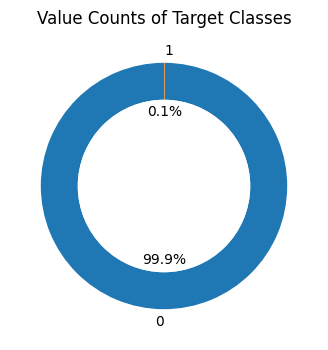

In [4]:
dist = df.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [5]:
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
df_test

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [6]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isic_id,401059,401059,ISIC_9999967,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,401059.0,NaN,NaN,NaN,0.00098,0.031288,0.0,0.0,0.0,0.0,1.0
patient_id,401059,1042,IP_1117889,9184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,398261.0,NaN,NaN,NaN,58.012986,13.596165,5.0,50.0,60.0,70.0,85.0
sex,389542,2,male,265546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,395303,5,posterior torso,121902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,401059.0,NaN,NaN,NaN,3.930827,1.743068,1.0,2.84,3.37,4.38,28.4
image_type,401059,1,TBP tile: close-up,401059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,401059,2,3D: XP,285903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,401059.0,NaN,NaN,NaN,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

## Data Transformation using Encoding and Normalization

In [8]:
df['tbp_lv_location_simple'] = df['tbp_lv_location_simple'].replace('Unknown', np.nan)

In [9]:
columns_to_drop = [
    'patient_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 
    'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type','lesion_id', 'iddx_full', 
    'iddx_1', 'attribution', 'copyright_license', 'image_type','tbp_lv_dnn_lesion_confidence','isic_id','target'
]


num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 
    'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

cat_cols = [
    'sex', 'anatom_site_general', 
    'tbp_lv_location', 'tbp_lv_location_simple', 
    'tbp_lv_symm_2axis_angle'
]
image_col = 'isic_id'

In [10]:
# Custom transformer to drop columns if they are present
class DropIfPresent(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns=columns_to_drop, errors='ignore')



# Define the pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='passthrough')  # Handle columns not specified in the transformers

pipeline = Pipeline([
    ('drop_columns', DropIfPresent(columns_to_drop=columns_to_drop)),
    ('preprocessor', preprocessor)
])

In [11]:
# Function to preprocess training data
def preprocess_train_data(df, pipeline):
    df_dropped = pipeline.named_steps['drop_columns'].transform(df)
    df_processed = pipeline.named_steps['preprocessor'].fit_transform(df_dropped)
    num_features = [col for col in num_cols if col in df_dropped.columns]
    cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_features, cat_features])
    df_processed = pd.DataFrame(df_processed, columns=all_features)    
    return df_processed

In [12]:
# Function to preprocess test data
def preprocess_test_data(df_test, pipeline):
    df_test_dropped = pipeline.named_steps['drop_columns'].transform(df_test)
    df_test_processed = pipeline.named_steps['preprocessor'].transform(df_test_dropped)
    num_features = [col for col in num_cols if col in df_test_dropped.columns]
    cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_features, cat_features])
    df_test_processed = pd.DataFrame(df_test_processed, columns=all_features)    
    return df_test_processed

In [13]:
target = list(df.target)
isic_id = list(df['isic_id'])

df_train_processed = preprocess_train_data(df, pipeline)
df_train_processed['target'] = target
df_train_processed['isic_id'] = isic_id

print("Processed Training Data:")
df_train_processed.head()


Processed Training Data:


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,target,isic_id
0,0.146658,-0.511069,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,-0.288931,-0.917620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015670
1,0.146658,-1.624050,2.935019,2.959583,-0.369545,-0.527265,1.126869,0.906538,-2.708061,-3.006591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015845
2,0.146658,-0.304536,0.650540,0.625867,1.835454,1.466075,1.644677,1.385391,0.835409,0.339647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015864
3,0.515699,-0.407803,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,0.318926,-0.166282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015902
4,-0.222383,-0.688917,1.188031,1.455843,-0.344179,-0.268249,0.250792,0.349419,-1.396095,-1.590171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0024200


In [14]:
for i in df_train_processed.columns:
    print(i,'     ',df_train_processed[i].dtypes)

age_approx       float64
clin_size_long_diam_mm       float64
tbp_lv_A       float64
tbp_lv_Aext       float64
tbp_lv_B       float64
tbp_lv_Bext       float64
tbp_lv_C       float64
tbp_lv_Cext       float64
tbp_lv_H       float64
tbp_lv_Hext       float64
tbp_lv_L       float64
tbp_lv_Lext       float64
tbp_lv_areaMM2       float64
tbp_lv_area_perim_ratio       float64
tbp_lv_color_std_mean       float64
tbp_lv_deltaA       float64
tbp_lv_deltaB       float64
tbp_lv_deltaL       float64
tbp_lv_deltaLB       float64
tbp_lv_deltaLBnorm       float64
tbp_lv_eccentricity       float64
tbp_lv_minorAxisMM       float64
tbp_lv_nevi_confidence       float64
tbp_lv_norm_border       float64
tbp_lv_norm_color       float64
tbp_lv_perimeterMM       float64
tbp_lv_radial_color_std_max       float64
tbp_lv_stdL       float64
tbp_lv_stdLExt       float64
tbp_lv_symm_2axis       float64
tbp_lv_x       float64
tbp_lv_y       float64
tbp_lv_z       float64
sex_female       float64
sex_male       floa

In [15]:
isic_id_test = list(df_test['isic_id'])

df_test_processed = preprocess_test_data(df_test, pipeline)
df_test_processed['isic_id'] = isic_id_test

print("Processed Test Data:")
df_test_processed

Processed Test Data:


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_135,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,isic_id
0,-0.960465,-0.706128,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,-1.330179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015657
1,-1.698546,-0.809394,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,1.716605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015729
2,0.515699,-0.442225,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575811,-1.079823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015740


In [16]:
df_test_processed

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_135,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,isic_id
0,-0.960465,-0.706128,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,-1.330179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015657
1,-1.698546,-0.809394,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,1.716605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015729
2,0.515699,-0.442225,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575811,-1.079823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015740



## Augementing Data using Synthetic Minority Over-sampling Technique


In [17]:
df_train_processed.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,target,isic_id
0,0.146658,-0.511069,0.067613,0.380443,-0.257500,-0.659882,-0.192995,-0.407543,-0.288931,-0.917620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015670
1,0.146658,-1.624050,2.935019,2.959583,-0.369545,-0.527265,1.126869,0.906538,-2.708061,-3.006591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015845
2,0.146658,-0.304536,0.650540,0.625867,1.835454,1.466075,1.644677,1.385391,0.835409,0.339647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015864
3,0.515699,-0.407803,-1.433104,-0.780446,-1.294561,-1.291919,-1.583639,-1.355725,0.318926,-0.166282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0015902
4,-0.222383,-0.688917,1.188031,1.455843,-0.344179,-0.268249,0.250792,0.349419,-1.396095,-1.590171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_0024200


In [18]:
# df_train_processed['isic_id'].isnull().sum()
# df_train_processed['isic_id'].value_counts().max()
df_train_processed = df_train_processed.groupby('target').apply(lambda x: x.sample(min(len(x), 35000 if x.name == 1 else 11000))).reset_index(drop=True)

df_train_processed

/tmp/ipykernel_24/3696830374.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_processed = df_train_processed.groupby('target').apply(lambda x: x.sample(min(len(x), 35000 if x.name == 1 else 11000))).reset_index(drop=True)


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,target,isic_id
0,0.515699,2.747556,0.201337,0.448601,0.012140,-0.086314,0.063054,0.066090,-0.162557,-0.512020,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,ISIC_8994473
1,0.884739,0.871552,-0.060394,-0.238783,-1.012226,-1.314513,-0.793273,-1.164391,-0.970306,-0.853328,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_2222671
2,-0.222383,-0.591387,0.075975,-0.915788,-0.192498,0.241496,-0.141349,-0.120950,-0.234111,1.126530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,ISIC_2712167
3,-2.436628,1.204299,0.451889,-0.497390,-0.601181,-1.305354,-0.271007,-1.259942,-1.013468,-0.533276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ISIC_1449871
4,0.515699,-0.235692,-0.766766,0.397150,-1.637364,-0.492440,-1.554253,-0.271600,-0.974425,-0.789518,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,ISIC_5172571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11388,0.884739,0.624860,-1.141094,-0.489399,-2.605082,-2.259260,-2.383484,-1.982220,-2.053488,-1.626874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ISIC_7323467
11389,0.884739,-0.447962,-1.130676,-0.660548,-0.721924,0.165967,-1.023964,-0.110639,0.557233,0.804485,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,ISIC_3825991
11390,0.146658,-0.826605,0.791438,1.436327,0.583993,0.385989,0.734000,0.829729,-0.194182,-1.048642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ISIC_7836717
11391,-0.222383,-1.314251,1.935907,1.658889,1.483271,0.919077,1.880644,1.330076,-0.391437,-0.851542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ISIC_0814829


In [19]:
# Directory containing the images
dir_path = '/kaggle/input/isic-2024-challenge/train-image/image'

# Load ISIC_ids from your DataFrame
isic_ids = df_train_processed['isic_id'].values

# Generate file paths based on ISIC_ids
image_paths = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in isic_ids]

# Check if image paths exist
valid_image_paths = [path for path in image_paths if os.path.exists(path)]

Original shape of ISIC_8994473.jpg: (165, 165, 3) - 3D (RGB)
Padded shape of ISIC_8994473.jpg: (128, 128, 3)


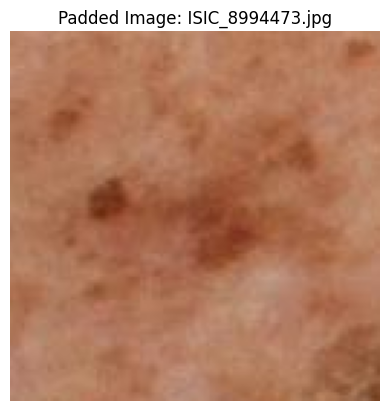

Original shape of ISIC_2222671.jpg: (137, 137, 3) - 3D (RGB)
Padded shape of ISIC_2222671.jpg: (128, 128, 3)


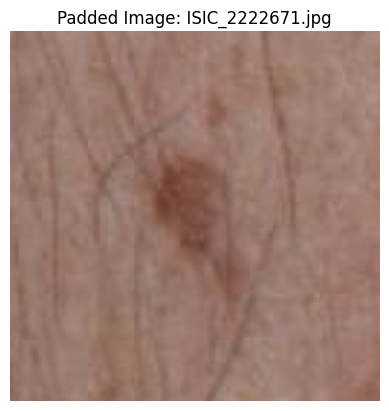

Original shape of ISIC_2712167.jpg: (127, 127, 3) - 3D (RGB)
Padded shape of ISIC_2712167.jpg: (128, 128, 3)


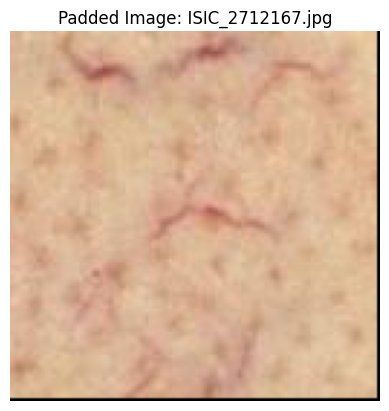

Original shape of ISIC_1449871.jpg: (115, 115, 3) - 3D (RGB)
Padded shape of ISIC_1449871.jpg: (128, 128, 3)


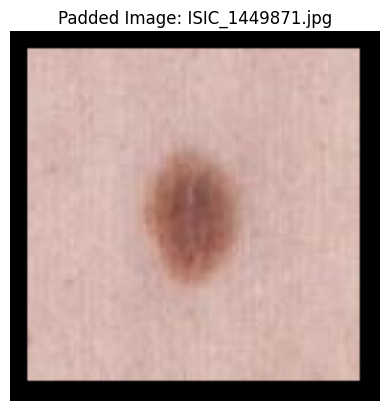

Original shape of ISIC_5172571.jpg: (171, 171, 3) - 3D (RGB)
Padded shape of ISIC_5172571.jpg: (128, 128, 3)


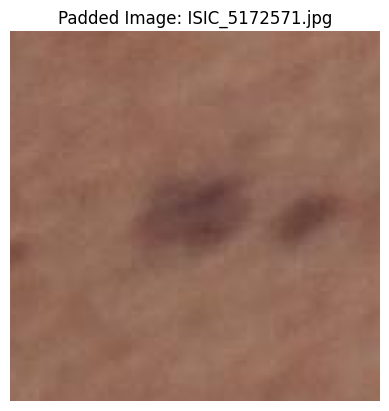

In [20]:
# Define the target size for padding
target_size = (128, 128)

# Function to pad an image to the target size
def pad_image(image, target_size):
    width, height = image.size
    new_image = Image.new("RGB", target_size, (0, 0, 0))  # Create a black background image
    new_image.paste(image, ((target_size[0] - width) // 2, (target_size[1] - height) // 2))
    return new_image

# Load, pad, and display the first five valid images
for image_path in valid_image_paths[:5]:
    # Load image
    image = Image.open(image_path)
    
    # Print original shape
    original_shape = np.array(image).shape
    print(f"Original shape of {os.path.basename(image_path)}: {original_shape} - {'3D (RGB)' if len(original_shape) == 3 else '2D (Grayscale)'}")
    
    # Pad image
    padded_image = pad_image(image, target_size)
    
    # Print new shape
    padded_shape = np.array(padded_image).shape
    print(f"Padded shape of {os.path.basename(image_path)}: {padded_shape}")
    
    # Display padded image
    plt.imshow(padded_image)
    plt.title(f"Padded Image: {os.path.basename(image_path)}")
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

Original shape of ISIC_8994473.jpg: (165, 165, 3) - 3D (RGB)
New shape of ISIC_8994473.jpg: (128, 128, 3)


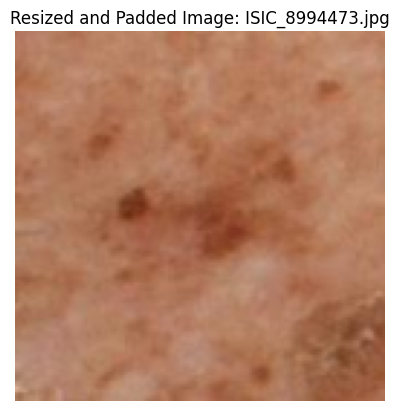

Original shape of ISIC_2222671.jpg: (137, 137, 3) - 3D (RGB)
New shape of ISIC_2222671.jpg: (128, 128, 3)


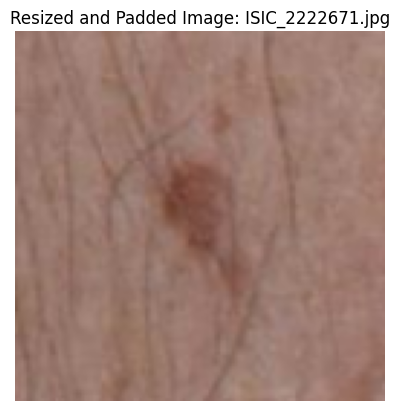

Original shape of ISIC_2712167.jpg: (127, 127, 3) - 3D (RGB)
New shape of ISIC_2712167.jpg: (128, 128, 3)


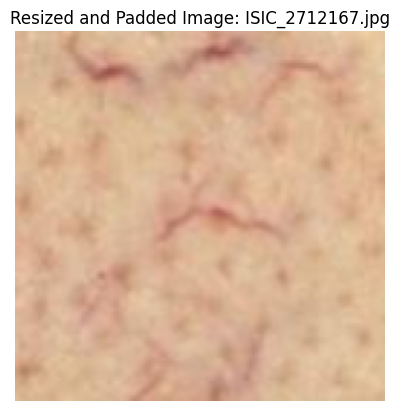

Original shape of ISIC_1449871.jpg: (115, 115, 3) - 3D (RGB)
New shape of ISIC_1449871.jpg: (128, 128, 3)


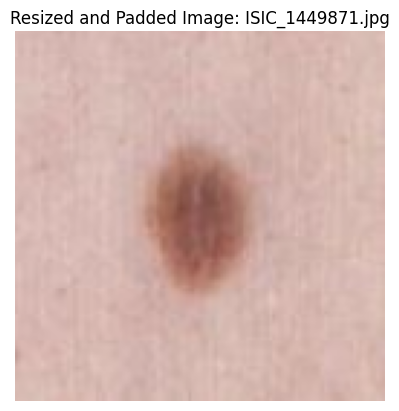

Original shape of ISIC_5172571.jpg: (171, 171, 3) - 3D (RGB)
New shape of ISIC_5172571.jpg: (128, 128, 3)


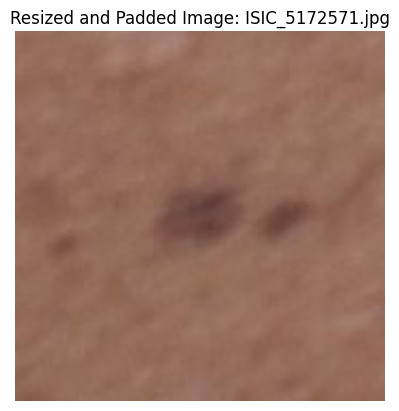

In [21]:
# Define the target size for padding
target_size = (128, 128)

# Function to resize and pad an image to the target size using nearest pixel values
def resize_and_pad_image(image, target_size):
    h, w = image.shape[:2]
    # Calculate the resize ratio to maintain aspect ratio
    ratio = min(target_size[0] / h, target_size[1] / w)
    new_size = (int(w * ratio), int(h * ratio))
    
    # Resize the image
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    
    # Calculate padding to reach the target size
    pad_h = target_size[0] - resized_image.shape[0]
    pad_w = target_size[1] - resized_image.shape[1]
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)
    
    # Pad image with nearest pixel values
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    return padded_image

# Load, resize, pad, and display the first five valid images
for image_path in valid_image_paths[:5]:
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Print original shape
    original_shape = image.shape
    print(f"Original shape of {os.path.basename(image_path)}: {original_shape} - {'3D (RGB)' if len(original_shape) == 3 else '2D (Grayscale)'}")
    
    # Resize and pad image
    resized_and_padded_image = resize_and_pad_image(image, target_size)
    
    # Print new shape
    new_shape = resized_and_padded_image.shape
    print(f"New shape of {os.path.basename(image_path)}: {new_shape}")
    
    # Display resized and padded image
    plt.imshow(resized_and_padded_image)
    plt.title(f"Resized and Padded Image: {os.path.basename(image_path)}")
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

In [22]:
# Separate features and target
X = df_train_processed.drop(columns=['target', 'isic_id'])
y = df_train_processed['target']

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=69)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a DataFrame from the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['target'] = y_resampled

# Identify the minority class
minority_class = y.value_counts().idxmin()
print(f"Minority class: {minority_class}")

# Get original isic_ids for the minority class
original_isic_ids = df_train_processed[df_train_processed['target'] == minority_class]['isic_id'].values

# Calculate the number of new samples generated
num_duplicates = sum(y_resampled == minority_class) - sum(y == minority_class)

# Generate new isic_id values for the resampled data
# Create unique new isic_ids for the new samples
existing_ids = set(df_train_processed['isic_id'].values)

new_isic_ids = []
for i in range(num_duplicates):
    new_id = f"ISIC_{i+1+len(existing_ids)}"
    while new_id in existing_ids:
        new_id = f"ISIC_{i+1+len(existing_ids)}_{i}"
    new_isic_ids.append(new_id)

# Combine original and new isic_ids
resampled_isic_ids = pd.concat([pd.Series(original_isic_ids)] * (num_duplicates // len(original_isic_ids) + 1), ignore_index=True).iloc[:num_duplicates]
resampled_isic_ids = pd.concat([pd.Series(df_train_processed['isic_id']), pd.Series(new_isic_ids)], ignore_index=True)

# Add new isic_ids to the resampled DataFrame
df_resampled['isic_id'] = resampled_isic_ids[:len(df_resampled)]

# Reorder columns to match the original structure
df_resampled = df_resampled[['isic_id'] + list(X.columns) + ['target']]

# Print the first few rows of the resampled DataFrame to verify

df_resampled.head()


Minority class: 1


/tmp/ipykernel_24/4056738786.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['target'] = y_resampled
/tmp/ipykernel_24/4056738786.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['isic_id'] = resampled_isic_ids[:len(df_resampled)]


,isic_id,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_symm_2axis_angle_135,tbp_lv_symm_2axis_angle_140,tbp_lv_symm_2axis_angle_145,tbp_lv_symm_2axis_angle_150,tbp_lv_symm_2axis_angle_155,tbp_lv_symm_2axis_angle_160,tbp_lv_symm_2axis_angle_165,tbp_lv_symm_2axis_angle_170,tbp_lv_symm_2axis_angle_175,target
0,ISIC_8994473,0.515699,2.747556,0.201337,0.448601,0.012140,-0.086314,0.063054,0.066090,-0.162557,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,ISIC_2222671,0.884739,0.871552,-0.060394,-0.238783,-1.012226,-1.314513,-0.793273,-1.164391,-0.970306,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,ISIC_2712167,-0.222383,-0.591387,0.075975,-0.915788,-0.192498,0.241496,-0.141349,-0.120950,-0.234111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,ISIC_1449871,-2.436628,1.204299,0.451889,-0.497390,-0.601181,-1.305354,-0.271007,-1.259942,-1.013468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,ISIC_5172571,0.515699,-0.235692,-0.766766,0.397150,-1.637364,-0.492440,-1.554253,-0.271600,-0.974425,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


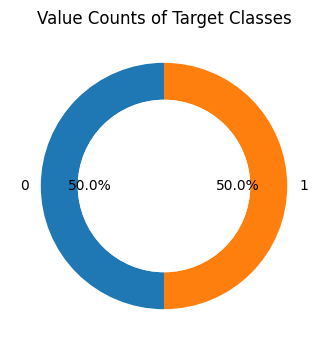

In [23]:
dist = df_resampled.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [24]:
df_resampled['target'].value_counts()

target
0    11000
1    11000
Name: count, dtype: int64

In [25]:
# # Optionally, find and show how many rows are the same in both DataFrames
# common_rows_resampled = pd.merge(df_resampled, df_train_processed, on='isic_id', how='inner')

# # Number of common rows
# num_common_rows = len(common_rows_resampled)
# print(f"Number of identical rows based on 'isic_id': {num_common_rows}")

In [26]:
# Generate file paths based on ISIC_ids
image_paths1 = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in original_isic_ids]

# Check if image paths exist
minority_class_image_paths = [path for path in image_paths1 if os.path.exists(path)]

In [27]:
# print(len(valid_image_paths))
# print(len(new_isic_ids))
image_size = len(new_isic_ids)

In [28]:
# Define the target size for padding
target_size = (128, 128)

# Function to resize and pad an image to the target size using nearest pixel values
def resize_and_pad_image(image, target_size):
    h, w = image.shape[:2]
    # Calculate the resize ratio to maintain aspect ratio
    ratio = min(target_size[0] / h, target_size[1] / w)
    new_size = (int(w * ratio), int(h * ratio))
    
    # Resize the image
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    
    # Calculate padding to reach the target size
    pad_h = target_size[0] - resized_image.shape[0]
    pad_w = target_size[1] - resized_image.shape[1]
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)
    
    # Pad image with nearest pixel values
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    return padded_image

# Paths
# dir_path = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/augmented_images'
os.makedirs(save_dir, exist_ok=True)



# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment and save images 400273
def augment_and_save_images(prepared_images, new_ids, save_dir, target_size=(128, 128, 3), num_new_images=143):
    num_images = len(prepared_images)
    new_rows = []

    images_per_original = num_new_images // num_images

    for idx, img in enumerate(prepared_images):
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            if i >= images_per_original:
                break

            new_image_name = f"{new_ids.pop(0)}.jpg"
            new_image_path = os.path.join(save_dir, new_image_name)
            save_img(new_image_path, batch[0])

            new_rows.append({'isic_id': new_image_name.replace('.jpg', ''), 'image_path': new_image_path})

            i += 1

    return new_rows

# Prepare stored images
prepared_images = []
for image_path in minority_class_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    prepared_img = resize_and_pad_image(img, target_size)
    save_img(os.path.join(save_dir, os.path.basename(image_path)), prepared_img)
    prepared_images.append(prepared_img)

# Generate new images for the minority class using prepared images
new_data = augment_and_save_images(prepared_images, new_isic_ids, save_dir)

# Convert the new data into a DataFrame
df_new_images = pd.DataFrame(new_data)

# Save the DataFrame to a CSV file
df_new_images.to_csv('/kaggle/working/new_images_metadata.csv', index=False)

print("Image augmentation and saving completed.")


Image augmentation and saving completed.


Majority class: 0


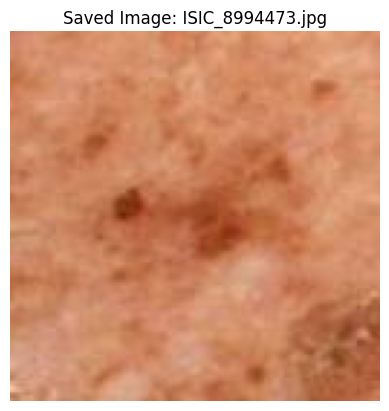

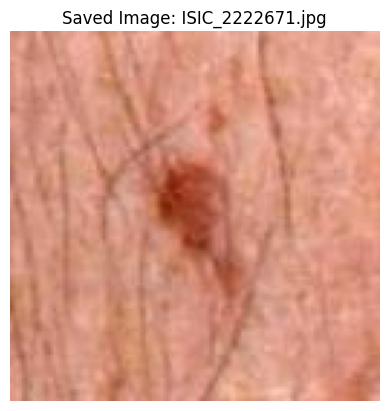

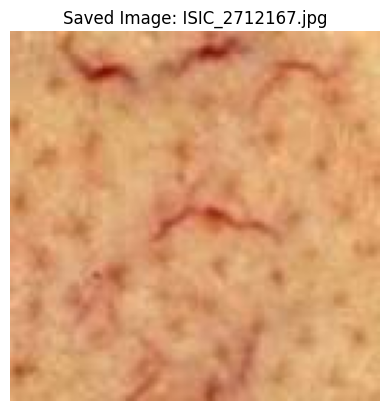

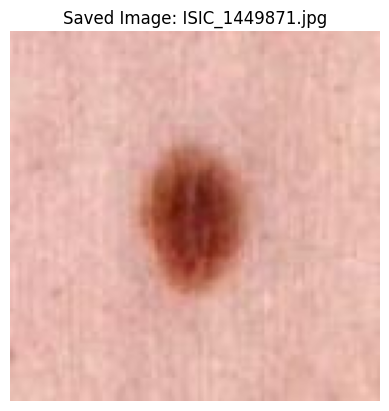

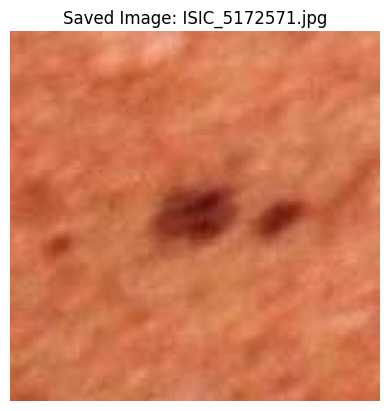

In [29]:
# Determine the majority class
majority_class = y.value_counts().idxmax()
print(f"Majority class: {majority_class}")

# Get original isic_ids for the majority class
original_isic_ids2 = df_train_processed[df_train_processed['target'] == majority_class]['isic_id'].values

# Generate file paths based on ISIC_ids
image_paths2 = [os.path.join(dir_path, f"{isic_id}.jpg") for isic_id in original_isic_ids2]

# Check if image paths exist
majority_class_image_paths = [path for path in image_paths2 if os.path.exists(path)]

# Resize, pad, and save the majority class images
for image_path in majority_class_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    prepared_img = resize_and_pad_image(img, target_size)
    save_img(os.path.join(save_dir, os.path.basename(image_path)), prepared_img)

# Verify a few saved images
saved_image_paths = [os.path.join(save_dir, f"{isic_id}.jpg") for isic_id in original_isic_ids2[:5]]
for path in saved_image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Saved Image: {os.path.basename(path)}")
    plt.axis('off')
    plt.show()

In [30]:
# Define the output directory where images are stored
output_dir = '/kaggle/working/augmented_images'

# Get a list of all image file paths in the output directory
all_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith('.jpg')]


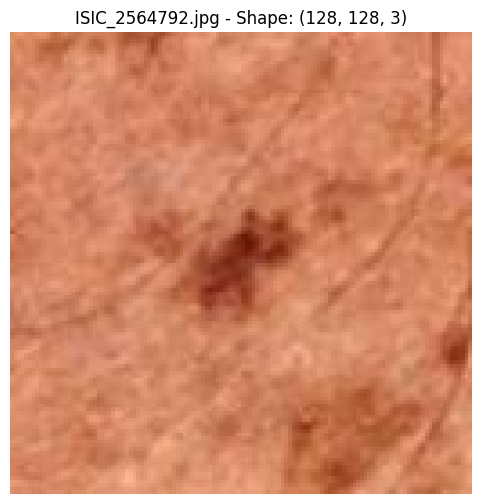

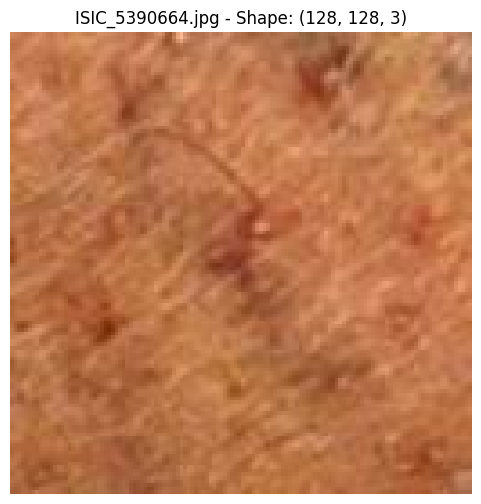

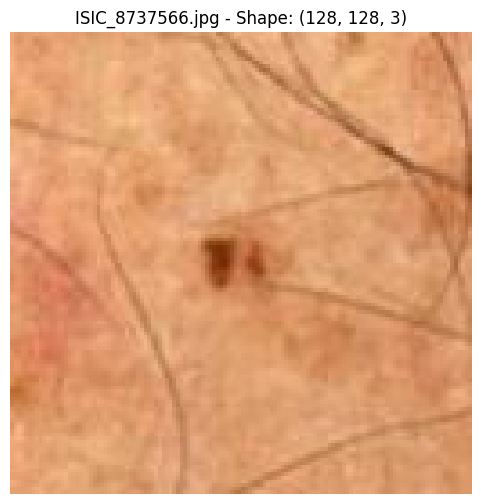

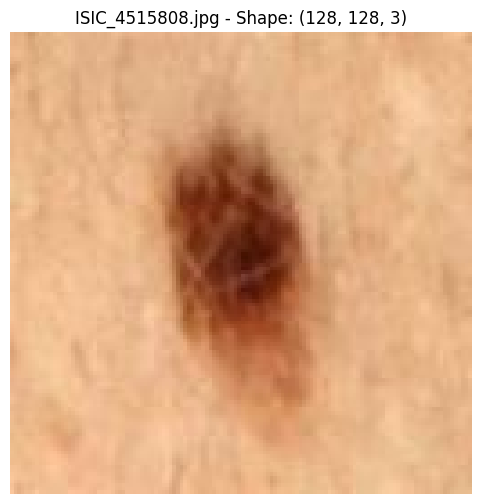

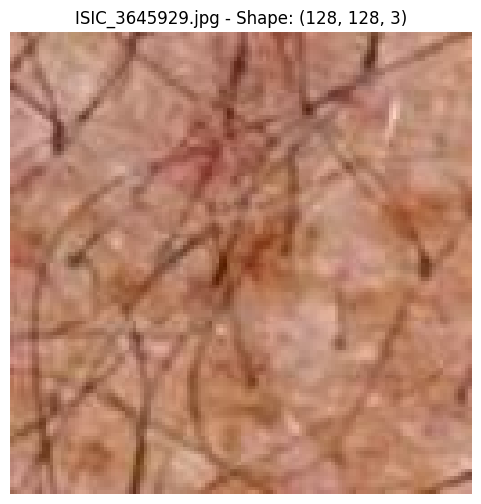

In [31]:
# Check if there are images in the directory
import random
if not all_image_paths:
    print("No images found in the output directory.")
else:
    # Number of images to display
    num_images_to_display = 5
    
    # Randomly select image paths
    selected_image_paths = random.sample(all_image_paths, min(num_images_to_display, len(all_image_paths)))
    
    # Display each randomly selected image in full size
    for image_path in selected_image_paths:
        # Load the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get the shape of the image
        shape = img.shape
        
        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"{os.path.basename(image_path)} - Shape: {shape}")
        plt.axis('off')
        plt.show()

In [32]:
# Shuffle and split the data
df_shuffled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

train_df, temp_df = train_test_split(df_shuffled, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Training samples: 15400
Validation samples: 3300
Test samples: 3300


In [33]:
def load_images(df, dir_path, target_size=(128, 128)):
    images = []
    for isic_id in df['isic_id']:
        image_path = os.path.join(dir_path, f"{isic_id}.jpg")
        if os.path.exists(image_path):
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
        else:
            img = np.zeros((128, 128, 3), dtype=np.uint8)  # Placeholder image
        images.append(img)
    return np.array(images)


In [34]:
output_dir = '/kaggle/working/augmented_images'

# Load images
train_images = load_images(train_df, output_dir)
val_images = load_images(val_df, output_dir)
test_images = load_images(test_df, output_dir)

# Extract tabular data
X_train_tab = train_df.drop(columns=['target', 'isic_id']).values
X_val_tab = val_df.drop(columns=['target', 'isic_id']).values
X_test_tab = test_df.drop(columns=['target', 'isic_id']).values

# Extract targets
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

# Convert to tensors
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

X_train_tab = tf.convert_to_tensor(X_train_tab, dtype=tf.float32)
X_val_tab = tf.convert_to_tensor(X_val_tab, dtype=tf.float32)
X_test_tab = tf.convert_to_tensor(X_test_tab, dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [35]:
print("Training data shape:", X_train_tab.shape)


Training data shape: (15400, 104)


In [36]:
def create_image_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    
    return Model(inputs, x, name="image_model")


In [37]:
def create_tabular_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x, name="tabular_model")


In [38]:
def create_combined_model(image_input_shape, tabular_input_shape):
    image_model = create_image_model(image_input_shape)
    tabular_model = create_tabular_model(tabular_input_shape)

    # Combine models
    combined = Concatenate()([image_model.output, tabular_model.output])
    x = Dense(128, activation='relu')(combined)
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[tabular_model.input, image_model.input], outputs=outputs)


In [39]:
# Define input shapes
tabular_input_shape = (104,)  # Update with actual shape if different
image_input_shape = (128, 128, 3)

# Create and compile the model
model = create_combined_model(image_input_shape, tabular_input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,720 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     36,992 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,528,033 (32.53 MB)

 Trainable params: 8,528,033 (32.53 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [41]:
history = model.fit(
    [X_train_tab, train_images], y_train,
    validation_data=([X_val_tab, val_images], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


2024-07-26 13:54:43.631905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-07-26 13:54:43.631996: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-07-26 13:54:43.632009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-07-26 13:54:43.632020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-07-26 13:54:43.632040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-07-26 13:54:43.632063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-07-26 13:54:43.632144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-07-26 13:54:43.632155: E exte

 10/482 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5404 - loss: 57.0689

I0000 00:00:1722002087.163172      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


477/482 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9367 - loss: 25.3578

2024-07-26 13:54:53.243002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.19276, expected 3.38235
2024-07-26 13:54:53.243075: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.49174, expected 4.68133
2024-07-26 13:54:53.243085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.83728, expected 5.02687
2024-07-26 13:54:53.243094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.14363, expected 4.33322
2024-07-26 13:54:53.243103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.75173, expected 3.94132
2024-07-26 13:54:53.243112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.04628, expected 4.23587
2024-07-26 13:54:53.243121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.21611, expected 3.40569
2024-07-26 13:54:53.243130: E external/local_xla/xla/se

482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9369 - loss: 25.2204

2024-07-26 13:54:57.466212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98304: 4.2055, expected 3.46583
2024-07-26 13:54:57.466301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98308: 5.0598, expected 4.32013
2024-07-26 13:54:57.466324: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98309: 5.15094, expected 4.41127
2024-07-26 13:54:57.466349: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98310: 5.6654, expected 4.92573
2024-07-26 13:54:57.466365: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98311: 4.73688, expected 3.9972
2024-07-26 13:54:57.466379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98312: 4.39242, expected 3.65274
2024-07-26 13:54:57.466393: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98313: 4.40308, expected 3.6634
2024-07-26 13:54:57.466406: E ex

482/482 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9370 - loss: 25.1932 - val_accuracy: 0.9797 - val_loss: 1.8450
Epoch 2/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9746 - loss: 5.2766 - val_accuracy: 0.9797 - val_loss: 74.6557
Epoch 3/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9793 - loss: 5.8079 - val_accuracy: 0.9800 - val_loss: 0.0575
Epoch 4/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9809 - loss: 0.0758 - val_accuracy: 0.9830 - val_loss: 0.0486
Epoch 5/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9870 - loss: 0.0413 - val_accuracy: 0.9818 - val_loss: 0.0459
Epoch 6/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9867 - loss: 0.0431 - val_accuracy: 0.9800 - val_loss: 0.0552
Epoch 7/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9874 - loss: 0.0408 - val_accuracy: 0.9800 - val_loss: 0.0515
Epoch 8/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9864 - loss: 0.0391 - val_accur

In [42]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test_tab, test_images], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict([X_test_tab, test_images])

# Convert probabilities to binary class labels (0 or 1)
class_predictions = (predictions > 0.5).astype(int).flatten()

# Assuming y_test contains the true labels for the test set
# Print the classification report
report = classification_report(y_test, class_predictions, target_names=['Class_0', 'Class_1'])
print(report)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9801 - loss: 0.0765
Test Loss: 0.05915902927517891
Test Accuracy: 0.9812121391296387
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

     Class_0       0.97      0.99      0.98      1649
     Class_1       0.99      0.97      0.98      1651

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



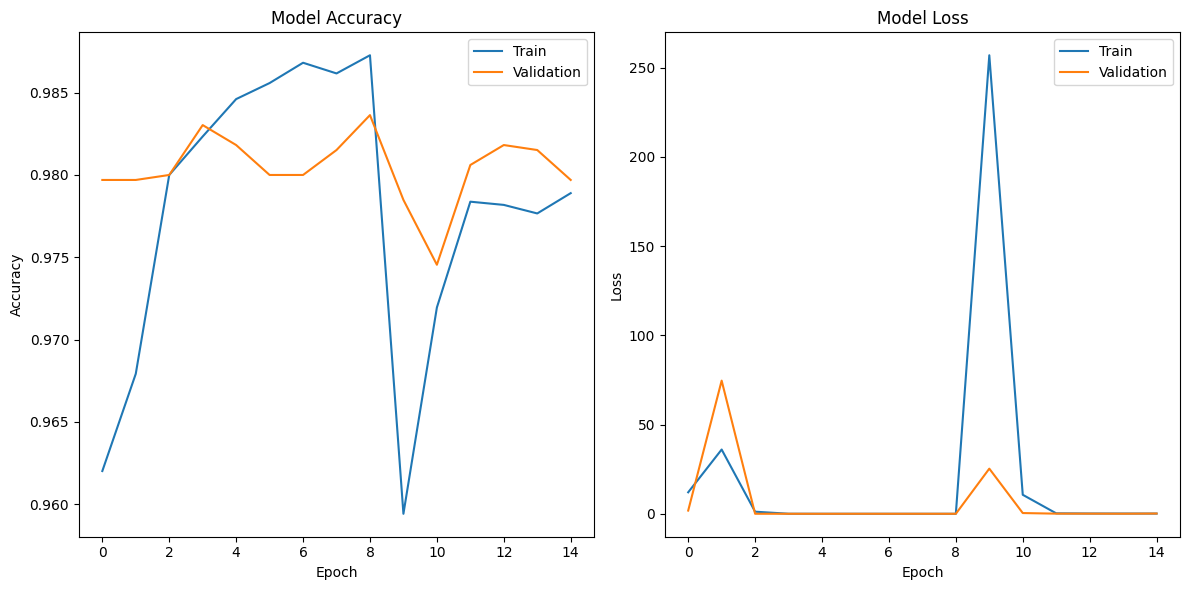

In [43]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [44]:
# Extract the tabular data (excluding 'isic_id' column)
X_test_tab = df_test_processed.drop(columns=['isic_id']).values

# Convert tabular data to a Tensor
X_test_tab_tensor = tf.convert_to_tensor(X_test_tab, dtype=tf.float32)

# Extract image IDs
image_ids = df_test_processed['isic_id'].values
image_ids

array(['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740'], dtype=object)

In [45]:
X_test_tab_tensor

<tf.Tensor: shape=(3, 104), dtype=float32, numpy=
array([[-0.9604646 , -0.7061276 ,  0.70767206,  1.4416198 ,  0.01940143,
         0.02913794,  0.28444767,  0.56295925, -0.6217763 , -1.3301792 ,
        -1.5932654 , -1.6598413 , -0.48485932,  0.7134371 , -0.7985919 ,
        -0.8542445 , -0.01273104,  0.8011894 , -0.8709177 , -0.28934738,
        -0.533672  , -0.30015218, -0.92821753,  1.1503508 , -0.9527611 ,
        -0.42093572, -0.9686929 , -0.824812  ,  0.09830369,  1.3797137 ,
        -0.77042973,  1.1508095 ,  0.6611111 ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
 

In [46]:
def resize_and_pad_image(image, target_size):
    # Convert image to TensorFlow tensor if not already
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Resize the image
    image = tf.image.resize(image, target_size, method='area')
    
    # Add padding to reach the target size
    target_height, target_width = target_size
    pad_height = target_height - tf.shape(image)[0]
    pad_width = target_width - tf.shape(image)[1]
    
    paddings = [[pad_height // 2, pad_height - pad_height // 2], 
                [pad_width // 2, pad_width - pad_width // 2], 
                [0, 0]]  # No padding on the channel dimension

    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    
    return image


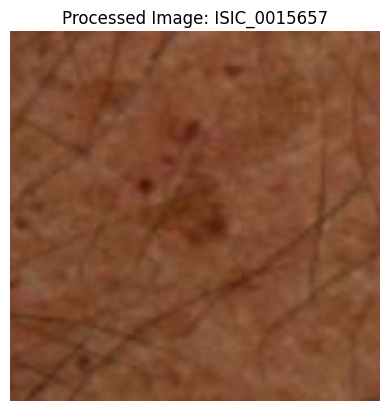

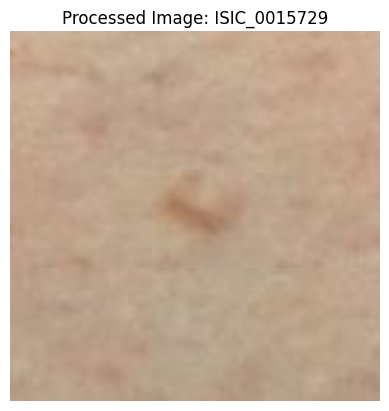

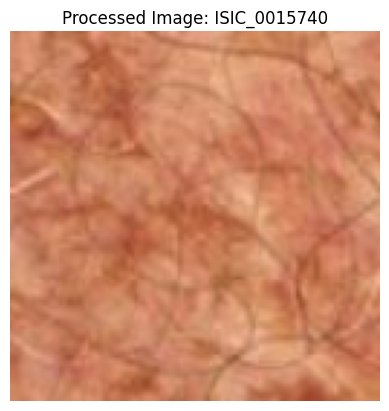

In [47]:
def load_and_process_images(hdf5_file_path, image_ids, target_size=(128, 128)):
    images = {}
    
    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        for image_id in image_ids:
            # Check if image_id exists in the file
            if image_id in hdf5_file:
                # Load image data
                image_data = hdf5_file[image_id][()]
                
                # Decode image data
                image_data = tf.image.decode_image(image_data, channels=3)
                image_data = tf.image.convert_image_dtype(image_data, dtype=tf.float32)
                
                # Resize and pad the image
                processed_image = resize_and_pad_image(image_data, target_size)
                
                images[image_id] = processed_image

    return images

# Define test image IDs
image_ids = ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']

# Load and process images
processed_images = load_and_process_images('/kaggle/input/isic-2024-challenge/test-image.hdf5', image_ids)

# Visualize the processed images
for image_id, image in processed_images.items():
    plt.figure()
    plt.title(f'Processed Image: {image_id}')
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()


In [48]:
# Convert processed images to a tensor
def images_to_tensor(image_dict):
    image_list = [image for image in image_dict.values()]
    return tf.stack(image_list)

# Prepare image tensors
X_test_images_tensor = images_to_tensor(processed_images)

# Load the model and make predictions
model = tf.keras.models.load_model('best_model.keras')




In [49]:
# Make predictions
predictions = model.predict([X_test_tab_tensor, X_test_images_tensor])

# Display predictions
print("Predictions:", predictions)

2024-07-26 13:56:40.539954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.34921, expected 2.46525
2024-07-26 13:56:40.540009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92983, expected 5.04587
2024-07-26 13:56:40.540019: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.86817, expected 4.98421
2024-07-26 13:56:40.540028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.9159, expected 4.03194
2024-07-26 13:56:40.540036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.84035, expected 3.95638
2024-07-26 13:56:40.540044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.60006, expected 3.7161
2024-07-26 13:56:40.540053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.34646, expected 3.4625
2024-07-26 13:56:40.540061: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
Predictions: [[0.6559747 ]
 [0.25907195]
 [0.78126377]]


In [50]:
predictions_df = pd.DataFrame({'isic_id': image_ids, 'target': predictions.flatten()})
predictions_df

,isic_id,target
0,ISIC_0015657,0.655975
1,ISIC_0015729,0.259072
2,ISIC_0015740,0.781264


In [51]:
predictions_df.to_csv('submission.csv', index=True)
